In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import torch
import os
from SLOPER import *
from utils import *

# Load DLPFC

In [7]:
# Load data
data_dir = "data"
file_folder = "151673"
path = os.path.join(data_dir, file_folder)
adata = sc.read_visium(path,count_file = "filtered_feature_bc_matrix.h5",load_images=True)
adata.var_names_make_unique()
df_meta = pd.read_csv(os.path.join(path, "metadata.tsv"), sep='\t')
df_meta_layer = df_meta['layer_guess']
adata.obs['ground_truth'] = df_meta_layer.values
adata = adata[~pd.isnull(adata.obs['ground_truth'])]

# Preprocess data
sc.pp.filter_genes(adata, min_cells=100)
adata.layers["raw_counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
orig_gene = adata.var.index.values

C:\Users\An Wang\AppData\Local\Temp\ipykernel_30052\1880350926.py:5: FutureWarning: Use `squidpy.read.visium` instead.
  adata = sc.read_visium(path,count_file = "filtered_feature_bc_matrix.h5",load_images=True)
c:\Users\An Wang\.conda\envs\vae-spatial\lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\An Wang\.conda\envs\vae-spatial\lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\An Wang\.conda\envs\vae-spatial\lib\site-packages\scanpy\preprocessing\_simple.py:287: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


# Load and normalize coordinate, prepare boundary weights and the push-in projector for boundary correction

1. prepare_coords(): Extracts spatial coordinates from the AnnData object and applies standard normalization (centering + scaling). You may replace coords_t with your own coordinates, but we strongly recommend normalizing them for stable gradient learning and boundary computations.
2. boundary_distances_and_gradients_torch(): Computes the signed distance to the tissue boundary for each coordinate, along with its spatial gradient and the boundary points used to construct the polygon geometry. These distances are required for truncated score-matching. Set visualize=True if you want to inspect the boundary.
3. build_sdf_projector(): builds a differentiable signed-distance-function (SDF) projector used by Langevin dynamics to keep simulated transcript locations inside the tissue polygon. This step can take ~1 minute to run, but the resulting projector can be reused for all genes, so you only need to build it once per dataset.

In [ ]:
coords_t = prepare_coords(adata, file_folder, normalize_coords=True) # a float32 PyTorch tensor
t_dists, t_grads, t_bpts,poly = boundary_distances_and_gradients_torch(coords_t,0.005,eps = .1, visualize = False)
projector = build_sdf_projector(poly, H=2048, W=2048, margin=0.5, device="cuda")

# Train SLOPER on individual gene

In [ ]:
# Choose the gene to model (example: PCP4)
gene = "PCP4" 
#Extracts the expression values of the gene from adata and applies optional lower-bound truncation (a_min=0). The returned vector is used as importance weights in the truncated score-matching loss. You may supply your own processed gene expression (after per-cell UMI normalization with no log-transformation) as weights vector here.
weights_t = prepare_weights(adata, gene, a_min = 0) # a float32 PyTorch tensor
# Initialize the score network:
model = ScoreNet(hidden_dim=64, depth=2, activation="softplus",use_fourier=False)
# Train the SLOPER model using truncated score matching:
train(
    model=model,
    coords=coords_t,
    weights=weights_t,
    distances=t_dists,
    grad_g0=t_grads,
    lr=1e-3,
    epochs=3000,
    weights_decay = 1e-4,
    step_size=300,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    gate_alpha=0,
    curl_eta=.5,
    log_every=500)

96.61835479736328 0.0
[Epoch 1/3000] loss = -0.0065
[Epoch 500/3000] loss = -13.3697
[Epoch 1000/3000] loss = -13.9376
[Epoch 1500/3000] loss = -13.9490
[Epoch 2000/3000] loss = -13.9491
[Epoch 2500/3000] loss = -13.9491
[Epoch 3000/3000] loss = -13.9491


# Enhance expression with annealed Langevin dynamics

In [15]:
# Get the score-model outputs (estimated ∇ log φ) at each spatial coordinate.
outs = get_model_outputs(model, coords_t)
# Identify the index of the current gene in the original gene list.
gene_idx = list(orig_gene).index(gene)
# Compute the total number of transcripts for this gene (using raw counts) as the number of Langevin-simulated transcript locations we will generate.
total_counts = int(np.asarray(adata.layers["raw_counts"].toarray()[:, gene_idx]).sum())
# Run Langevin dynamics to sample M = total_counts transcript locations inside the tissue polygon. The SDF projector ensures samples stay inside.
samples = sample_ld_in_polygon_sdf(
    model, projector,
    M=total_counts, 
    T=800, 
    eps=0.15,
    sigma_noise=1.0, alpha=0.999,
    project_every=1, project_iters=1, push_in=1e-3,
    poly=poly
)
# Convert simulated transcript locations into spot-level enhanced expression:
enhanced_feature = counts_from_samples_nearest(
                coords_t, samples.detach().cpu(), return_assignments=False
            )

# Plot enhanced expression and the gradient

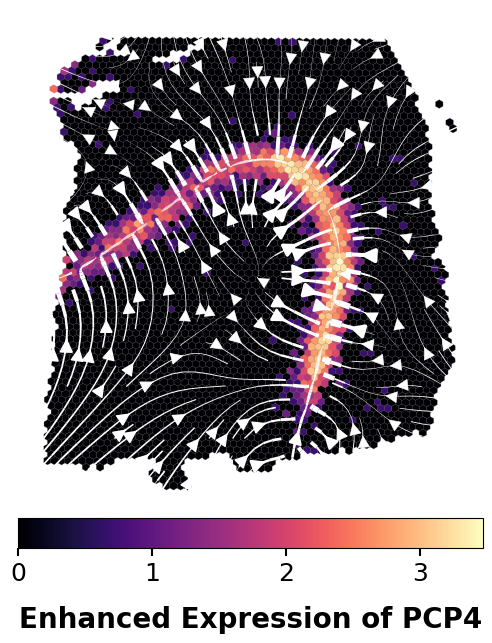

In [ ]:
# Visualize the learned spatial gradient together with the Langevin-enhanced gene expression. We plot:
#  (1) a streamline plot of the estimated ∇ log φ field (outs["score"])
#  (2) a scatter background colored by log-transformed enhanced expression.
fig, ax = plot_streamlines_from_scores(
    coords_t,
    outs["score"].detach().cpu().numpy(),
    grid_density=1.0,
    smooth=.5,
    n_neighbors=None,      # auto-choose
    min_mass=1,            # IMPORTANT: numeric when adjust_for_stream=True
    cutoff_perc=0,
    seed_density=1.2,
    arrowsize=2,
    base_linewidth=5.5,
    counts = np.log1p(enhanced_feature),
    title="",
    color_bar_name=f"Enhanced Expression of {gene}",
    minlength=0.05
)

# Additional Examples

14.716702461242676 0.0
[Epoch 1/3000] loss = -0.0157
[Epoch 500/3000] loss = -7.9557
[Epoch 1000/3000] loss = -8.7030
[Epoch 1500/3000] loss = -8.7177
[Epoch 2000/3000] loss = -8.7178
[Epoch 2500/3000] loss = -8.7178
[Epoch 3000/3000] loss = -8.7178


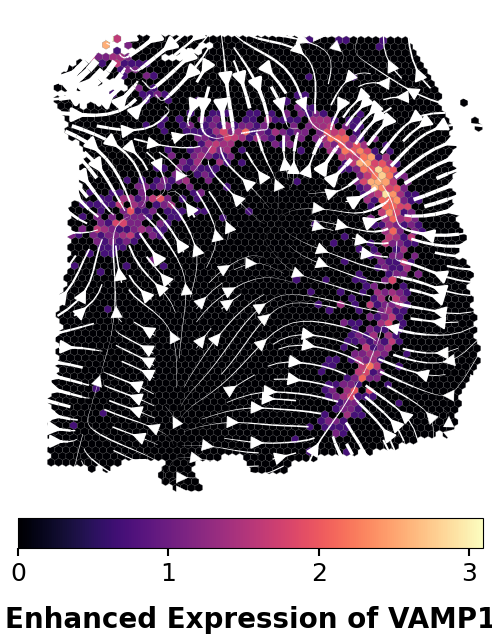

In [17]:
gene = "VAMP1" 
weights_t = prepare_weights(adata, gene, a_min = 0)
model = ScoreNet(hidden_dim=64, depth=2, activation="softplus",use_fourier=False)
train(
    model=model,
    coords=coords_t,
    weights=weights_t,
    distances=t_dists,
    grad_g0=t_grads,
    lr=1e-3,
    epochs=3000,
    weights_decay = 1e-4,
    step_size=300,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    gate_alpha=0,
    curl_eta=.5,
    log_every=500)
outs = get_model_outputs(model, coords_t)
gene_idx = list(orig_gene).index(gene)
total_counts = int(np.asarray(adata.layers["raw_counts"].toarray()[:, gene_idx]).sum())
samples = sample_ld_in_polygon_sdf(
    model, projector,
    M=total_counts, 
    T=800, 
    eps=0.15,
    sigma_noise=1.0, alpha=0.999,
    project_every=1, project_iters=1, push_in=1e-3,
    poly=poly
)
enhanced_feature = counts_from_samples_nearest(
                coords_t, samples.detach().cpu(), return_assignments=False
            )
fig, ax = plot_streamlines_from_scores(
    coords_t,
    outs["score"].detach().cpu().numpy(),
    grid_density=1.0,
    smooth=.5,
    n_neighbors=None,      # auto-choose
    min_mass=1,            # IMPORTANT: numeric when adjust_for_stream=True
    cutoff_perc=0,
    seed_density=1.2,
    arrowsize=2,
    base_linewidth=5.5,
    counts = np.log1p(enhanced_feature),
    title="",
    color_bar_name=f"Enhanced Expression of {gene}",
    minlength=0.05
)

48.30917739868164 0.0
[Epoch 1/3000] loss = 0.2325
[Epoch 500/3000] loss = -3.9077
[Epoch 1000/3000] loss = -4.0979
[Epoch 1500/3000] loss = -4.1017
[Epoch 2000/3000] loss = -4.1018
[Epoch 2500/3000] loss = -4.1018
[Epoch 3000/3000] loss = -4.1018


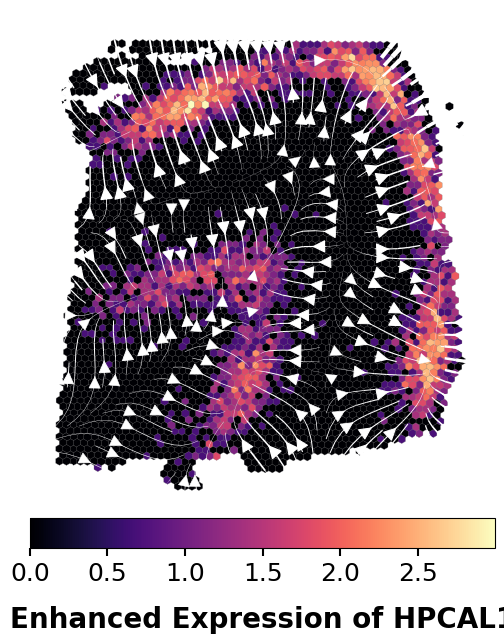

In [18]:
gene = "HPCAL1" 
weights_t = prepare_weights(adata, gene, a_min = 0)
model = ScoreNet(hidden_dim=64, depth=2, activation="softplus",use_fourier=False)
train(
    model=model,
    coords=coords_t,
    weights=weights_t,
    distances=t_dists,
    grad_g0=t_grads,
    lr=1e-3,
    epochs=3000,
    weights_decay = 1e-4,
    step_size=300,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    gate_alpha=0,
    curl_eta=.5,
    log_every=500)
outs = get_model_outputs(model, coords_t)
gene_idx = list(orig_gene).index(gene)
total_counts = int(np.asarray(adata.layers["raw_counts"].toarray()[:, gene_idx]).sum())
samples = sample_ld_in_polygon_sdf(
    model, projector,
    M=total_counts, 
    T=800, 
    eps=0.15,
    sigma_noise=1.0, alpha=0.999,
    project_every=1, project_iters=1, push_in=1e-3,
    poly=poly
)
enhanced_feature = counts_from_samples_nearest(
                coords_t, samples.detach().cpu(), return_assignments=False
            )
fig, ax = plot_streamlines_from_scores(
    coords_t,
    outs["score"].detach().cpu().numpy(),
    grid_density=1.0,
    smooth=.5,
    n_neighbors=None,      # auto-choose
    min_mass=1,            # IMPORTANT: numeric when adjust_for_stream=True
    cutoff_perc=0,
    seed_density=1.2,
    arrowsize=2,
    base_linewidth=5.5,
    counts = np.log1p(enhanced_feature),
    title="",
    color_bar_name=f"Enhanced Expression of {gene}",
    minlength=0.05
)